In [32]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [33]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure5'

In [34]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [35]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [36]:
def go_plot(table, n_top=25, filename=None):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, (1, 3))
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.round(np.linspace(0, top['adj_p_val'].max(), 4), 2), rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.linspace(0, n_genes.max(), 4),
        np.round(np.linspace(0, n_genes.max(), 4), 2),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

In [37]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Oligolineage

596090


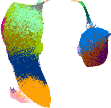

In [33]:
plt.figure(None, (2, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:

    print(ds.shape[1])

    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.UMAP[cells, 0], ds.ca.UMAP[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig('/home/kimberly/figures/figure5/oligolineage_umap.pdf', dpi=300)

# Region distribution

In [7]:
roi_grp_order = [
        'Cerebral cortex',
        'Hippocampus',
        'Claustrum',
        'Basal nuclei',
        'Basal forebrain',
        'Amygdaloid complex',
        'Extended amygdala',
        'Hypothalamus',
        'Thalamus', 
        'Midbrain',
        'Cerebellum',
        'Pons',
        'Myelencephalon',
        'Spinal cord'
    ]

In [8]:
df = pd.read_csv('roi_group_table.csv')
df.head()

,Unnamed: 0,index,ROI Group,Order,ROI Group Coarse
0,78,Human A13,Cerebral cortex,0,Cerebral cortex
1,81,Human A14,Cerebral cortex,0,Cerebral cortex
2,45,Human A19,Cerebral cortex,0,Cerebral cortex
3,68,Human A1C,Cerebral cortex,0,Cerebral cortex
4,61,Human A23,Cerebral cortex,0,Cerebral cortex


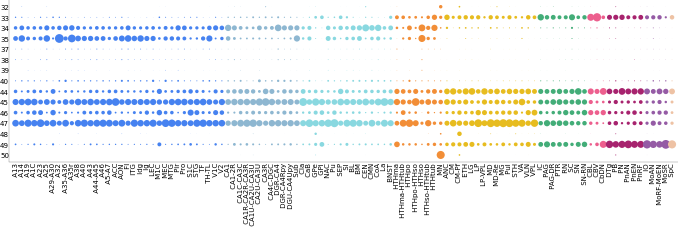

In [31]:
plt.figure(None, (12, 3))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.agg.loom', 'r') as ds:
    ordering = hc.leaves_list(ds.attrs.euclidean_linkage)
    cluster_dict = dict(zip(ordering, ds.ca.Clusters))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    euclidean_clusters = np.array([cluster_dict.get(x) for x in ds.ca.ClusterName])
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    roi_attr = clean_roi(ds.ca.Roi)
    total_counts = np.array([(roi_attr == r).sum() for r in rois])
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]
    clusters, labels = np.unique(
        euclidean_clusters,
        return_inverse=True
    )
    
    roi_counts = []
    x = []
    y = []
    colors = []
    for i, r in enumerate(rois):
        agg = npg.aggregate(labels, roi_attr == r) / total_counts[i]
        roi_counts.append(agg)
        x.append( [i] * len(clusters) )
        y.append( range(len(clusters)) )
        c = color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]]
        colors = colors + [c] * len(clusters)

    roi_counts = np.hstack(roi_counts)
    x = np.hstack(x)
    y = np.hstack(y)

    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=True, lw=0)
    ax.tick_params(length=0)
    ax.invert_yaxis()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(range(len(clusters)), clusters, fontsize=7)
    plt.margins(0.01, 0.05)
        
    plt.savefig('/home/kimberly/figures/figure5/oligolineage_region_dot.pdf', dpi=300)

In [17]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    for c in np.unique(ds.ca.Clusters):
        roi_counts = []
        colors = []
        for r in df['ROI Group Coarse'].unique():
            count = ( (roi_attr == r) & (ds.ca.Clusters == c) ).sum()
            roi_counts.append(count)
            colors.append(color_dict[r])
            
        # plot pie chart
        plt.figure(None, (0.5, 0.5))
        plt.pie(roi_counts, colors=colors)
        plt.show()

# Oligodendrocytes

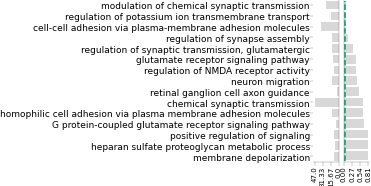

In [286]:
with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:
    top_genes = ds.ra.Gene[ds.ra.Selected == 1]
    df = gget.enrichr(top_genes, database="ontology")
    go_plot(df, n_top=15, filename='/home/kimberly/figures/figure5/top_variable_GO.pdf')

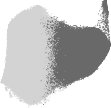

In [63]:
plt.figure(None, (2, 2))

with loompy.connect(folder + 'harmony_B_A.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['dimgray' if l == 0 else 'lightgray' for l in labels])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig('/home/kimberly/figures/figure5/oligo_type.pdf', dpi=300)

8


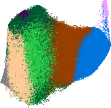

In [80]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = ds.ca.Clusters
    print(ds.ca.Clusters.max() + 1)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    # for c in np.unique(ds.ca.Clusters):
    #     mean = ds.ca.TSNE[ds.ca.Clusters == c].mean(axis=0)
    #     ax.text(mean[0], mean[1], c, fontsize=7)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.savefig('/home/kimberly/figures/figure5/oligo_clusters.pdf', dpi=300)

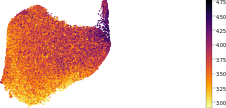

In [71]:
plt.figure(None, (4, 2))

with loompy.connect(f'{folder}/harmony_B_A.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=2, lw=0, rasterized=True, cmap='inferno_r')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
        
    plt.savefig('/home/kimberly/figures/figure5/oligo_umi.pdf', dpi=300)

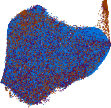

In [66]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = ds.ca.Donor
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/oligo_donor.pdf', dpi=300)

In [56]:
with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:
    print(((ds.ca.Roi[ds.ca.Clusters == 0] == 'Human MN') & (ds.ca.Donor[ds.ca.Clusters == 0] == 'H19.30.001')).sum() / (ds.ca.Clusters == 0).sum())

0.8820630749014454


In [49]:
with loompy.connect(folder + 'harmony_B_A.agg.loom', 'r') as ds:
    top_genes = ds.ra.Gene[np.argsort(ds['enrichment'][:, 0])[::-1]][:20]
top_genes[~np.isin(top_genes, ncRNA_genes)]

array(['MDFIC2', 'COL10A1'], dtype=object)

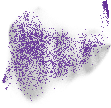

In [72]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = ds.ca.Donor
    
    cells = ds.ca.Roi == 'Human MN'
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/oligo_MN.pdf', dpi=300)

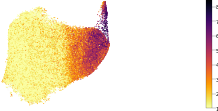

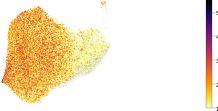

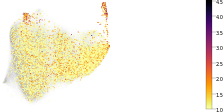

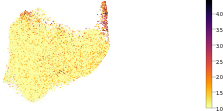

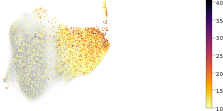

In [104]:
for g in ['RBFOX1', 'OPALIN', 'MDFIC2', 'COL10A1', 'CD44']:

    with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

        plt.figure(None, (4, 2))

        ax = plt.subplot(121)
        exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0

        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

        plt.axis('off')
        plt.margins(0.02, 0.02)

        ax = plt.subplot(122)
        plt.axis('off')
        cbar = plt.colorbar(ax=ax)
        cbar.ax.tick_params(labelsize=5)

        plt.subplots_adjust(wspace=0, hspace=0)

        plt.savefig(f'/home/kimberly/figures/figure5/oligo_{g}.pdf', dpi=300)

# Mouse oligos

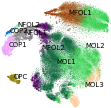

In [95]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:

    labels = ds.ca.ClusterName
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, alpha=0.3, rasterized=True)
    for c in np.unique(ds.ca.ClusterName):
        mean = ds.ca.TSNE[ds.ca.ClusterName == c].mean(axis=0)
        ax.text(mean[0], mean[1], c, fontsize=7)
    plt.margins(0.01, 0.01)
    plt.axis('off')

    # flip axis to mirror human
    ax.invert_xaxis()
    
    plt.savefig('/home/kimberly/figures/figure5/oligo_mouse_clusters.pdf', dpi=300)

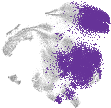

In [103]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:

    labels = ds.ca.ClusterName
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.1, s=1, lw=0, rasterized=True)
    cells = labels == 'MOL2'
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')

    # flip axis to mirror human
    ax.invert_xaxis()
    
    plt.show()

In [82]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:
    print(np.unique(ds.ca.Tissue))

['Amygd' 'CA1' 'CB' 'Ctx1' 'Ctx1.5' 'Ctx2' 'Ctx3' 'DentGyr' 'HC' 'Hypoth'
 'MBd' 'MBv' 'Medulla' 'OB' 'Pons' 'SC' 'SScortex' 'StriatDor'
 'StriatVent' 'Thal']


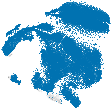

In [85]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/mouse_oligos.loom', 'r') as ds:

    cells = pd.Series(ds.ca.Tissue).isin(['Pons', 'Medulla', 'MBd', 'MBv', 'SC', 'Hypoth', 'Thal', 'CB'])
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', s=1, alpha=0.05, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # flip axis to mirror human
    ax.invert_xaxis()
    
    plt.savefig('/home/kimberly/figures/figure5/oligo_mouse_non-tel.pdf', dpi=300)

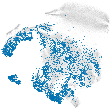

In [84]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/mouse/data/Oligos.loom', 'r') as ds:

    cells = pd.Series(ds.ca.Tissue).str.contains('x') | pd.Series(ds.ca.Tissue).isin(['Amygd', 'CA1', 'DentGyr', 'HC', 'StriatVent'])
    
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', s=1, alpha=0.05, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # flip axis to mirror human
    ax.invert_xaxis()
    
    plt.savefig('/home/kimberly/figures/figure5/oligo_mouse_tel.pdf', dpi=300)

# OPCs

(array(['dimgray', 'lightgray'], dtype='<U9'), array([49068, 55023]))


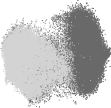

In [176]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['dimgray' if l == 1 else 'lightgray' for l in labels])
    
    print(np.unique(colors, return_counts=True))
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    plt.savefig('/home/kimberly/figures/figure5/opc_type.pdf', dpi=300)

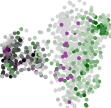

In [186]:
with loompy.connect('/proj/human_adult/mouse/data/Oligos_OPCs.loom', 'r') as ds:
    
    genes = ["Hes5", "Irx5", "Top2a"]
    cmaps = ['darkgreen', 'purple', 'black']

    plt.figure(None, (2, 2))
    
    scatterm(
        ds.ca.TSNE, 
        c=[np.log2(ds[ds.ra.Gene == g, :].flatten() + 1) for g in genes],
        cmaps=cmaps,
        bgval=0,
        labels=genes,
        rasterized=True,
        s=15,
        legend=None,
        max_percentile=99.7
    )
    plt.margins(0.01, 0.01)
    plt.axis('off')
    # plt.savefig('/home/kimberly/figures/figure5/opc_mouse.pdf', dpi=300)

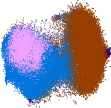

In [167]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = ds.ca.Clusters
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    # for c in np.unique(ds.ca.Clusters):
    #     mean = ds.ca.TSNE[ds.ca.Clusters == c].mean(axis=0)
    #     ax.text(mean[0], mean[1], c, fontsize=7)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    plt.savefig('/home/kimberly/figures/figure5/opc_clusters.pdf', dpi=300)

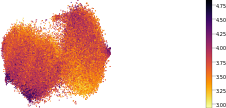

In [168]:
plt.figure(None, (4, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
    
    ax = plt.subplot(121)
    
    # color by top group
    labels = np.log10(ds.ca.TotalUMI)
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=labels[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
        
    plt.savefig('/home/kimberly/figures/figure5/opc_umi.pdf', dpi=300)

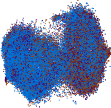

In [169]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = ds.ca.Donor
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colorize(labels[cells]), s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    plt.savefig(f'{figure_folder}/opc_donor.pdf', dpi=300)

In [119]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
    t1, t2 = np.unique(ds.ca.Donor[ds.ca.Clusters == 3], return_counts=True)
    print(
        dict(zip(t1, t2))
    )

{'H18.30.001': 1, 'H18.30.002': 207, 'H19.30.001': 464, 'H19.30.002': 257}


In [120]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
    print(((ds.ca.Roi[ds.ca.Clusters == 3] == 'Human MN')).sum() / (ds.ca.Clusters == 3).sum())

0.5457481162540366


In [122]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:
    top_genes = ds.ra.Gene[np.argsort(ds['enrichment'][:, 3])[::-1]][:20]
top_genes[~np.isin(top_genes, ncRNA_genes)]

array(['FMO3'], dtype=object)

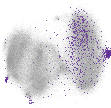

In [205]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = ds.ca.Donor
    
    cells = ds.ca.Roi == 'Human MN'
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    plt.savefig(f'{figure_folder}/opc_MN.pdf', dpi=300)

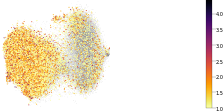

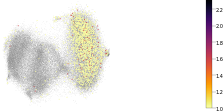

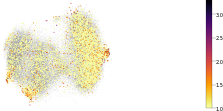

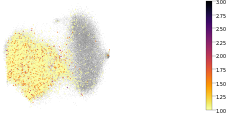

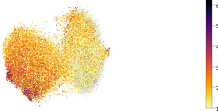

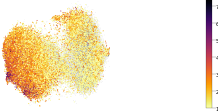

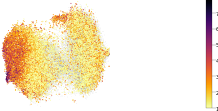

In [206]:
for g in ['HES5', 'IRX5', 'FMO3', 'FOXG1', 'NELL1', 'CNTN5', 'GPC5']:

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

        plt.figure(None, (4, 2))

        ax = plt.subplot(121)
        exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0

        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

        plt.axis('off')
        plt.margins(0.02, 0.02)
        
        # invert x-axis so type 1 is telencephalon like in oligos
        ax.invert_xaxis()

        ax = plt.subplot(122)
        plt.axis('off')
        cbar = plt.colorbar(ax=ax)
        cbar.ax.tick_params(labelsize=5)

        plt.subplots_adjust(wspace=0, hspace=0)

        plt.savefig(f'/home/kimberly/figures/figure5/opcs_{g}.pdf', dpi=300)

# Type 1/2 Distributions

In [190]:
def plot_type_bars(ds, regions, type_labels, color_dict, outfile):
    
    # roi group coarse from Pool
    with loompy.connect(folder + 'Pool.loom', 'r') as ds_pool:
        cell_dict = dict(zip(ds_pool.ca.CellID, ds_pool.ca.ROIGroupCoarse))

    # get ROI grp attr
    region_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    # get ROIs and order by ROI Groups
    total_counts = [(region_attr == r).sum() for r in regions]

    type1 = []
    type2 = []
    colors = []
    for i, r in enumerate(regions):
        is_region = region_attr == r
        type1.append( ( (type_labels == 0) & is_region).sum() )
        type2.append( ( (type_labels == 1) & is_region).sum() )
        colors.append(color_dict[r])

    type1 = np.array(type1) / total_counts
    type2 = -1 * np.array(type2) / total_counts

    plt.figure(None, (3, 2))
    plt.subplot(211)
    plt.bar(range(len(regions)), type1, color=colors)
    plt.axis('off')
    plt.subplot(212)
    plt.bar(range(len(regions)), type2, color=colors)
    plt.axis('off')
    plt.savefig(outfile, dpi=300)
    plt.show()

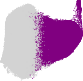

In [191]:
plt.figure(None, (1.5, 1.5))

with loompy.connect(folder + 'harmony_B_A.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['purple' if l == 0 else 'lightgray' for l in labels])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.show()

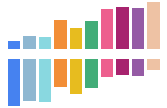

In [192]:
with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:
    
    regions = df['ROI Group Coarse'].unique()
    # 0 is non-telencephalon. Make 0 telencephalon
    type_labels = (labels == 1).astype('int') 
    outfile = '/home/kimberly/figures/figure5/oligo_type_bars.pdf'
    
    plot_type_bars(ds, regions, type_labels, color_dict, outfile)

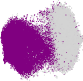

In [193]:
plt.figure(None, (1.5, 1.5))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:

    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    colors = np.array(['purple' if l == 0 else 'lightgray' for l in labels])
    
    cells = np.random.permutation(ds.shape[1])
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=colors[cells], s=1, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    # invert x-axis so type 1 is telencephalon like in oligos
    ax.invert_xaxis()
    
    plt.show()

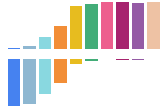

In [194]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:
        
    regions = df['ROI Group Coarse'].unique()
    # 0 is telencephalon. Keep telencephalon 0.
    type_labels = (labels == 0).astype('int') 
    outfile = '/home/kimberly/figures/figure5/opc_type_bars.pdf'
    
    plot_type_bars(ds, regions, type_labels, color_dict, outfile)

# Oligodendrocyte turnover

In [38]:
from scipy.stats import ks_2samp, mannwhitneyu

In [39]:
def get_ratios_by_attr(ds, clusters1, clusters2, attr, unique_attr):
        
    ratios = []
    
    for x in unique_attr:
        is_attr = attr == x
        count1 = ( is_attr & np.isin(ds.ca.ClusterName, clusters1) ).sum()
        count2 = ( is_attr & np.isin(ds.ca.ClusterName, clusters2) ).sum()
        ratios.append( count1 / count2 )

    return ratios

def plot_jitter(all_ratios, outfile, width=0.4, s=20, ymax=None, ylabel=None):
    
    plt.figure(None, (1.1, 0.9))
    ax = plt.subplot(111)
    
    for n in [0, 1]:
        x = np.array([n] * len(all_ratios[n]))
        plt.scatter(
            np.random.uniform(x - width, n + width), 
            all_ratios[n],
            c=all_colors[n],
            s=10,
            rasterized=True
        )
        
    if ymax is not None:
        plt.ylim(0, ymax)
    
    plt.margins(0.1, 0.1)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5, rotation=90)
    
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=5)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
        
    plt.savefig(outfile, dpi=300)
    plt.show()

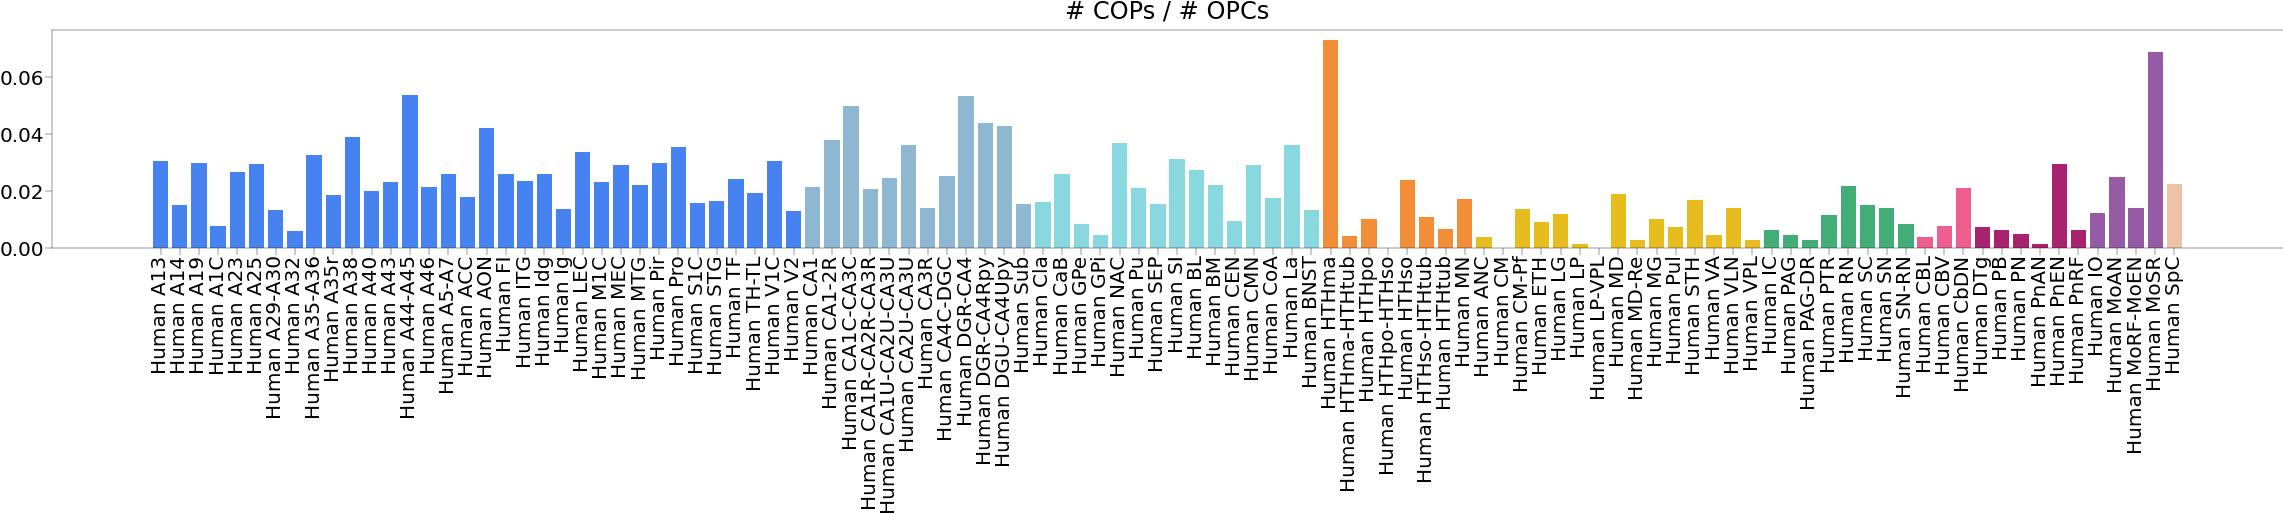

In [40]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    cop_clusters = [408, 409, 388]
    opc_clusters = [404, 405, 406, 407]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    rois = df['index'].to_numpy()

    ratios = get_ratios_by_attr(ds, cop_clusters, opc_clusters, roi_attr, rois)
    colors = [color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]] for r in rois]
    
plt.figure(None, (20, 2), dpi=144)
plt.bar(range(len(ratios)), ratios, color=colors)
plt.xticks(range(len(ratios)), rois, rotation=90)
plt.title( '# COPs / # OPCs' )
plt.show()

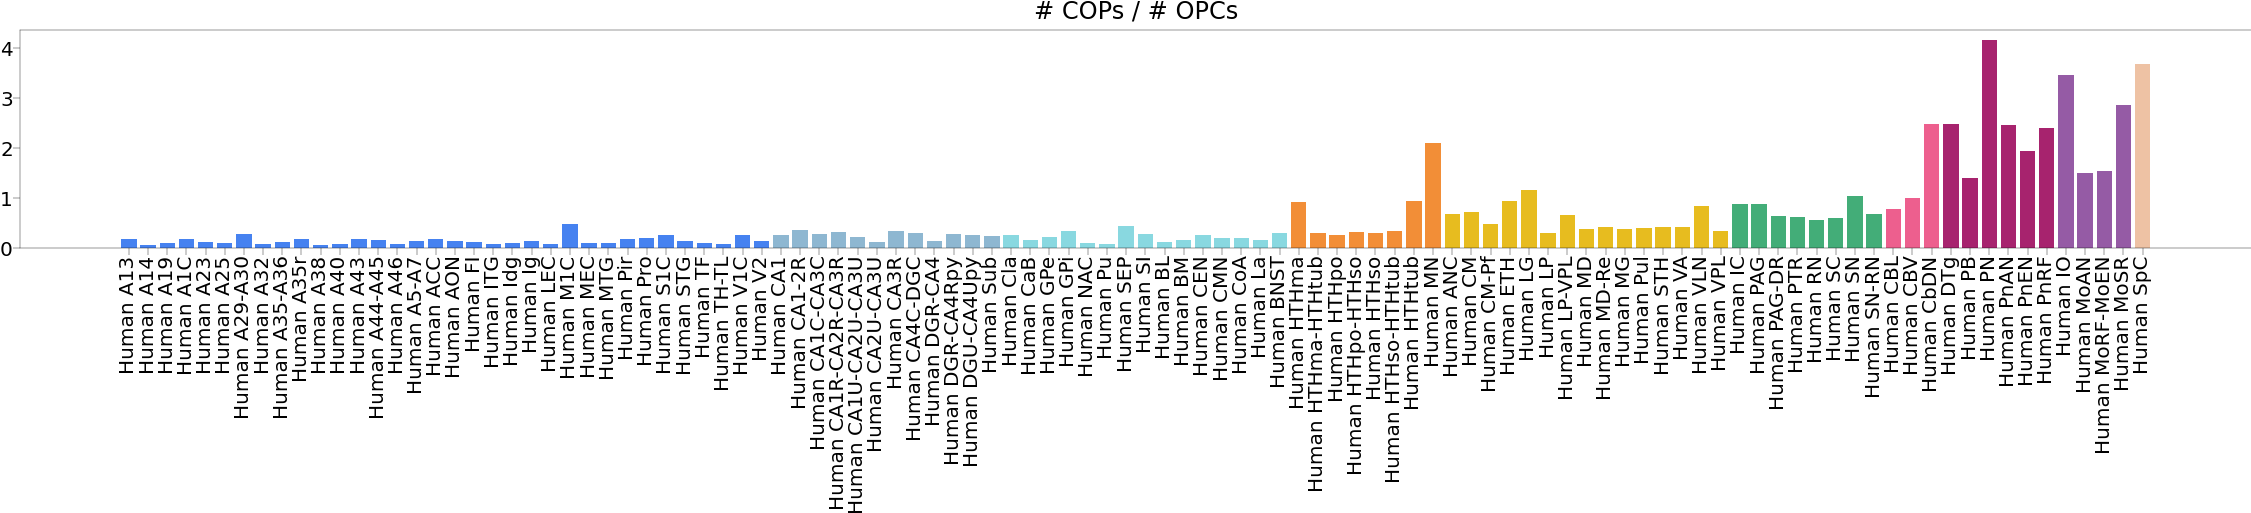

In [41]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    rbfox_clusters = [378, 379, 377]
    opalin_clusters = [384, 385, 386, 387]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    rois = df['index'].to_numpy()

    ratios = get_ratios_by_attr(ds, rbfox_clusters, opalin_clusters, roi_attr, rois)
    colors = [color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]] for r in rois]
    
plt.figure(None, (20, 2), dpi=144)
plt.bar(range(len(ratios)), ratios, color=colors)
plt.xticks(range(len(ratios)), rois, rotation=90)
plt.title( '# COPs / # OPCs' )
plt.show()

In [42]:
tel_regions = [
        'Cerebral cortex',
        'Hippocampus',
        'Claustrum',
        'Basal nuclei',
        'Basal forebrain',
        'Amygdaloid complex',
        'Extended amygdala'
]

non_tel_regions = [
        'Hypothalamus',
        'Thalamus', 
        'Midbrain',
        'Cerebellum',
        'Pons',
        'Myelencephalon',
        'Spinal cord'
]

In [43]:
tel_rois = df[df['ROI Group Coarse'].isin(tel_regions)]['index'].to_numpy()
non_tel_rois = df[df['ROI Group Coarse'].isin(non_tel_regions)]['index'].to_numpy()
tel_rois, non_tel_rois

(array(['Human A13', 'Human A14', 'Human A19', 'Human A1C', 'Human A23',
        'Human A25', 'Human A29-A30', 'Human A32', 'Human A35-A36',
        'Human A35r', 'Human A38', 'Human A40', 'Human A43',
        'Human A44-A45', 'Human A46', 'Human A5-A7', 'Human ACC',
        'Human AON', 'Human FI', 'Human ITG', 'Human Idg', 'Human Ig',
        'Human LEC', 'Human M1C', 'Human MEC', 'Human MTG', 'Human Pir',
        'Human Pro', 'Human S1C', 'Human STG', 'Human TF', 'Human TH-TL',
        'Human V1C', 'Human V2', 'Human CA1', 'Human CA1-2R',
        'Human CA1C-CA3C', 'Human CA1R-CA2R-CA3R', 'Human CA1U-CA2U-CA3U',
        'Human CA2U-CA3U', 'Human CA3R', 'Human CA4C-DGC', 'Human DGR-CA4',
        'Human DGR-CA4Rpy', 'Human DGU-CA4Upy', 'Human Sub'], dtype=object),
 array(['Human HTHma', 'Human HTHma-HTHtub', 'Human HTHpo',
        'Human HTHpo-HTHso', 'Human HTHso', 'Human HTHso-HTHtub',
        'Human HTHtub', 'Human MN', 'Human ANC', 'Human CM', 'Human CM-Pf',
        'Human ETH', '

In [44]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    cop_clusters = [408, 409, 388]
    opc_clusters = [404, 405, 406, 407]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    all_ratios = []
    all_colors = []
    
    for rois in [tel_rois, non_tel_rois]:
        
        ratios = get_ratios_by_attr(ds, cop_clusters, opc_clusters, roi_attr, rois)
        all_ratios.append(ratios)
        
        colors = [color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]] for r in rois]
        all_colors.append(colors)

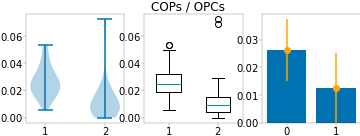

In [45]:
fig = plt.figure(None, (6, 2))
st = fig.suptitle("COPs / OPCs")
plt.subplot(131)
plt.violinplot(all_ratios)
plt.subplot(132)
plt.boxplot(all_ratios, widths=0.5)
plt.subplot(133)
means = np.mean(all_ratios[0]), np.mean(all_ratios[1])
errors = np.std(all_ratios[0]), np.mean(all_ratios[1])
plt.bar(range(2), means)
plt.errorbar(range(2), means, yerr=errors, fmt='o', color='orange')
plt.show()

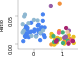

In [46]:
outfile = '/home/kimberly/figures/figure5/ratio_COP_to_OPC.pdf'
plot_jitter(all_ratios, outfile, ylabel='Ratio')

In [47]:
ks_2samp(all_ratios[0], all_ratios[1]), mannwhitneyu(all_ratios[0], all_ratios[1])

(KstestResult(statistic=0.6251207729468599, pvalue=9.867729889898763e-09),
 MannwhitneyuResult(statistic=1772.0, pvalue=5.022164751465671e-09))

In [32]:
with loompy.connect(folder + 'harmony_B_A.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect(folder + 'harmony_B_A.loom', 'r') as ds:

    labels = clades[ds.ca.Clusters].flatten()
    type1 = np.unique(ds.ca.Clusters[labels == 0])
    print(type1)
    type2 = np.unique(ds.ca.Clusters[labels == 1])
    print(type2)
    
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    print(np.unique(ds.ca.Clusters[(ds.ca.Punchcard == 'harmony_B_A') & np.isin(ds.ca.PunchcardClusters, type1)]))
    print(np.unique(ds.ca.Clusters[(ds.ca.Punchcard == 'harmony_B_A') & np.isin(ds.ca.PunchcardClusters, type2)]))

[0 1 2]
[3 4 5 6 7]
[377 378 379]
[383 384 385 386 387]


In [33]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    type1_clusters = [377, 378, 379]
    type2_clusters = [383, 384, 385, 386, 387]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    all_ratios = []
    all_colors = []
    
    for rois in [tel_rois, non_tel_rois]:
        
        ratios = get_ratios_by_attr(ds, type1_clusters, type2_clusters, roi_attr, rois)
        all_ratios.append(ratios)
        
        colors = [color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]] for r in rois]
        all_colors.append(colors)

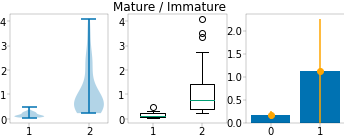

In [34]:
fig = plt.figure(None, (6, 2))
st = fig.suptitle("Mature / Immature ")
plt.subplot(131)
plt.violinplot(all_ratios)
plt.subplot(132)
plt.boxplot(all_ratios, widths=0.5)
plt.subplot(133)
means = np.mean(all_ratios[0]), np.mean(all_ratios[1])
errors = np.std(all_ratios[0]), np.mean(all_ratios[1])
plt.bar(range(2), means)
plt.errorbar(range(2), means, yerr=errors, fmt='o', color='orange')
plt.show()

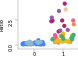

In [35]:
outfile = '/home/kimberly/figures/figure5/ratio_type1_to_type2.pdf'
plot_jitter(all_ratios, outfile, ylabel='Ratio')

In [36]:
ks_2samp(all_ratios[0], all_ratios[1]), mannwhitneyu(all_ratios[0], all_ratios[1])

(KstestResult(statistic=0.8690821256038648, pvalue=1.2654977378792116e-18),
 MannwhitneyuResult(statistic=41.0, pvalue=3.1100110342006205e-15))

In [37]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    oligo_clusters = [377, 378, 379, 383, 384, 385, 386, 387]
    opc_clusters = [404, 405, 406, 407]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    all_ratios = []
    all_colors = []
    
    for rois in [tel_rois, non_tel_rois]:
        
        ratios = get_ratios_by_attr(ds, oligo_clusters, opc_clusters, roi_attr, rois)
        all_ratios.append(ratios)
        
        colors = [color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]] for r in rois]
        all_colors.append(colors)

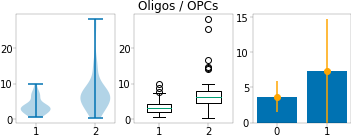

In [38]:
fig = plt.figure(None, (6, 2))
st = fig.suptitle("Oligos / OPCs")
plt.subplot(131)
plt.violinplot(all_ratios)
plt.subplot(132)
plt.boxplot(all_ratios, widths=0.5)
plt.subplot(133)
means = np.mean(all_ratios[0]), np.mean(all_ratios[1])
errors = np.std(all_ratios[0]), np.mean(all_ratios[1])
plt.bar(range(2), means)
plt.errorbar(range(2), means, yerr=errors, fmt='o', color='orange')
plt.show()

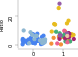

In [39]:
outfile = '/home/kimberly/figures/figure5/ratio_oligo_to_opc.pdf'
plot_jitter(all_ratios, outfile, ylabel='Ratio')

In [40]:
ks_2samp(all_ratios[0], all_ratios[1]), mannwhitneyu(all_ratios[0], all_ratios[1])

(KstestResult(statistic=0.538647342995169, pvalue=1.393676847097882e-06),
 MannwhitneyuResult(statistic=511.0, pvalue=3.2450989848426325e-05))

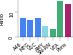

In [48]:
# set up data

eel_oligo_dict = {
    'A46': 1836,
    'MTG': 1969,
    'V1C': 6319,
    'AMY': 379,
    'VTA': 1102, 
    'SN-RN': 237,
    'Pons': 751
}

eel_opc_dict = {
    'A46': 232,
    'MTG': 277,
    'V1C': 802,
    'AMY': 83,
    'VTA': 76, 
    'SN-RN': 75,
    'Pons': 57
}

# get regions in order
eel_regions = ['A46', 'MTG', 'V1C', 'AMY', 'SN-RN', 'VTA', 'Pons']
eel_oligos = np.array([eel_oligo_dict[x] for x in eel_regions])
eel_opcs = np.array([eel_opc_dict[x] for x in eel_regions])

# get colors for each region
regions = ['Cerebral cortex', 'Cerebral cortex', 'Cerebral cortex', 'Cerebral nuclei', 'Midbrain', 'Midbrain', 'Pons']
colors = [color_dict[x] for x in regions]

# plot
plt.figure(None, (1, 0.7))
plt.bar(range(len(regions)), eel_oligos / eel_opcs, color=colors)
plt.xticks(range(len(regions)), eel_regions, rotation=40, fontsize=5, ha='right')
plt.yticks(fontsize=5, rotation=90)
plt.ylabel('Ratio', fontsize=5)
plt.savefig(f'/home/kimberly/figures/figure5/ratio_oligo_to_opc_eel.pdf', dpi=300)

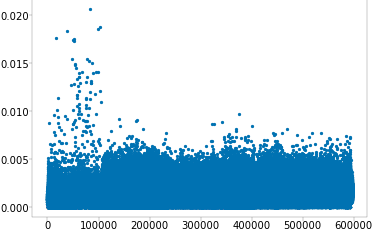

In [277]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    plt.scatter(range(ds.shape[1]), ds.ca.CellCycle, s=5)

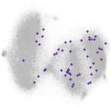

In [132]:
plt.figure(None, (2, 2))

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    labels = ds.ca.CellCycle
    
    cells = labels > 0.01
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c='grey', alpha=0.01, s=5, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=5, lw=0, rasterized=True)
    plt.margins(0.01, 0.01)
    plt.axis('off')
    plt.show()

In [50]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, clean_roi(ds.ca.Roi)))
    
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean.loom', 'r') as ds:
    
    opc_clusters = [404, 405, 406, 407]
    
    roi_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])

    all_ratios = []
    for rois in [tel_rois, non_tel_rois]:
        
        cycling_opcs = []
        
        for r in rois:
            
            # get relevant bools
            is_opc = np.isin(ds.ca.ClusterName, opc_clusters)
            is_region = roi_attr == r
            is_cycling = ds.ca.CellCycle > 0.01
            
            # get numerator and denominator bools
            num = is_opc & is_region & is_cycling
            denom = is_opc & is_region
            
            # count cycling opcs
            cycling_opcs.append( num.sum() / denom.sum() )
            
            if num.sum() / denom.sum() > 0.005:
                print(r)
            
        all_ratios.append(cycling_opcs)

Human AON
Human Pro
Human CA2U-CA3U
Human HTHma


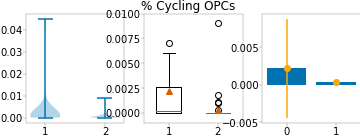

In [51]:
fig = plt.figure(None, (6, 2))
st = fig.suptitle("% Cycling OPCs")
plt.subplot(131)
plt.violinplot(all_ratios)
plt.subplot(132)
plt.boxplot(all_ratios, widths=0.5, showmeans=True)
plt.ylim(-0.001, 0.01)
plt.subplot(133)
means = np.mean(all_ratios[0]), np.mean(all_ratios[1])
errors = np.std(all_ratios[0]), np.mean(all_ratios[1])
plt.bar(range(2), means)
plt.errorbar(range(2), means, yerr=errors, fmt='o', color='orange')
plt.show()

In [55]:
(np.array(all_ratios[0]) > 0.01).sum(), (np.array(all_ratios[1]) > 0.01).sum()

(1, 0)

In [56]:
np.array(all_ratios[0])[np.array(all_ratios[0]) > 0.01]

array([0.04504505])

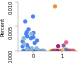

In [52]:
outfile = '/home/kimberly/figures/figure5/ratio_cycling_opc.pdf'
plot_jitter(all_ratios, outfile, ymax=0.01, ylabel='Percent')

In [45]:
ks_2samp(all_ratios[0], all_ratios[1]), mannwhitneyu(all_ratios[0], all_ratios[1])

(KstestResult(statistic=0.4111111111111111, pvalue=0.0004118532380740143),
 MannwhitneyuResult(statistic=1455.0, pvalue=4.628641788681705e-05))